In [1]:
from __future__ import division
from nilmtk.dataset_converters import convert_ampds
from nilmtk import DataSet
from nilmtk.utils import print_dict
from pylab import rcParams
#import simpy
import random
import statistics
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt



In [2]:
def load_market_data():
    for i in range(2, 20):
        df = pd.DataFrame()
        if(i>9):
            df = df.append(
                pd.read_csv('./data/energy_price/PUB_PriceHOEPPredispOR_20'+str(i)+'.csv', skiprows=3))
        else: 
            df = df.append(
                pd.read_csv('./data/energy_price/PUB_PriceHOEPPredispOR_200'+str(i)+'.csv', skiprows=3))
        df = clean_market_data(df)
    return df

def clean_market_data(df):
    try:
        df['HOEP'] = pd.to_numeric(df['HOEP'].str.replace(',', ''))
    except:
        print("Already Number")
    return df

def load_data():
    ampds = DataSet("./data/load_profile/AMPds2.h5")
    dataset = {}
    nam_map = {}
    elec = ampds.buildings[1].elec
    for item in range(1,20):
        appl = elec.meters.__getitem__(item)
        name = appl.appliances[0].metadata.get('original_name')
        arr = []
        for g in appl.load():
            arr.append(g)
        df = pd.DataFrame(arr[0])
        df.columns = [ 'pf_ap', 'reactive', 'apparent', 'active']
        dataset[name]= df
        dataset[name+"_INFO"] = elec.meters.__getitem__(item).appliances[0].metadata
    return dataset

def weather_data():
    climate = pd.read_csv('./data/load_profile/Climate_HourlyWeather.csv')
    drop = ['Data Quality', 'Temp Flag', 'Dew Point Temp Flag', 'Wind Spd Flag', 'Stn Press Flag',
          'Hmdx Flag', 'Wind Chill Flag', 'Wind Dir Flag', 'Rel Hum Flag', 'Visibility Flag']
    climate = climate.drop(columns = drop, axis=1)
    return climate



In [3]:
ds = load_data()

In [10]:

print(ds['TVE'].describe()['apparent']['count'] )
print(ds['TVE'].astype(bool).sum(axis=0)['apparent'])

1051200.0
1038529


In [ ]:
def get_rands_from_data(inputdata, num):

    print(inputdata)
    data = inputdata.fillna(0)
    hist, bins = np.histogram(data, bins=50)

    bin_midpoints = bins[:-1] + np.diff(bins)/2
    cdf = np.cumsum(hist)
    cdf = cdf / cdf[-1]
    values = np.random.rand(num)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = bin_midpoints[value_bins]

    plt.subplot(121)
    plt.hist(data, 50)
    plt.subplot(122)
    plt.hist(random_from_cdf, 50)
    plt.show()
    print(random_from_cdf)

0        28.0
1        17.0
2        26.0
3        39.0
4        30.0
         ... 
17515    21.0
17516    14.0
17517     7.0
17518    10.0
17519     4.0
Name: Wind Spd (km/h), Length: 17520, dtype: float64


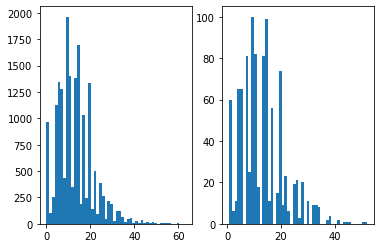

[19.53 10.71 13.23 18.27  5.67 17.01  9.45 25.83 19.53 19.53 22.05  6.93
  3.15 23.31 14.49 10.71  0.63 13.23  0.63 17.01 22.05  9.45 13.23 20.79
 11.97  4.41  4.41  0.63  5.67 38.43 14.49 22.05 10.71 19.53 34.65 24.57
  5.67  5.67 11.97 13.23  0.63  5.67  4.41  6.93 11.97  6.93 10.71 14.49
  5.67 29.61 17.01 13.23 13.23  9.45 14.49 29.61  6.93 19.53  9.45  5.67
 19.53 17.01  9.45  9.45  9.45 22.05  9.45  6.93 29.61 19.53  6.93  6.93
 32.13  4.41  6.93 23.31 13.23 27.09 25.83  1.89  5.67 13.23 13.23  5.67
 25.83  9.45  9.45 19.53 19.53  8.19  5.67 14.49  0.63 28.35  4.41 28.35
  5.67  0.63 19.53 17.01 14.49  6.93  5.67 24.57 13.23 24.57  4.41  1.89
 19.53  0.63 14.49  9.45  9.45  6.93  9.45  0.63 19.53 13.23 13.23  0.63
 14.49  6.93 24.57  5.67  4.41  9.45 17.01 24.57  1.89 24.57 10.71 13.23
 13.23 33.39  4.41  9.45 13.23 10.71 17.01  9.45  4.41 10.71 14.49  9.45
  0.63  9.45 19.53 10.71 17.01 29.61 17.01 17.01  4.41  6.93 14.49 17.01
 19.53 24.57 11.97 14.49 22.05  9.45  8.19 17.01  8

In [30]:
test = weather_data()
get_rands_from_data( test["Wind Spd (km/h)"], 1000)

In [12]:
class Meter(object):

    load_distros = []
    load_infos = []

    #structure of load infos - 
    # - is_controllable
    # - state_connection
    # - time_triggers
    #consumption of power by appliances on time step

    loads = []
    states = []
    durations = []
    state_targets = []

    net_load = 0
    #power_thresh = 200
    
    def __init__(self, json_path):
        params = json.load(open(json_path))

In [13]:
class House(object):
    
    controls = []
    trigger_probs = []
    duration_distros = []
    
    meter = Meter('house_params.json')
    timestep = 0
    
    
    def __init__(self, env, json_path):
        self.env = env
        print(str(params))
        self.meter.meter = Meter(json_path)


    def update_state(self):
        infos = self.meter.load_infos
        for i in range(0, infos):
            #state connection is in format [effect when on, effect when off], 2 numbers
            #TODO add in state initialization
            if infos[i]['state_connection'][0]>0 and self.controls[i]:
                self.meter.states[i]+=infos[i]['state_connection'][0]
            else :
                self.meter.states[i]+=infos[i]['state_connection'][1]

            if self.meter.durations[i]>0:
                self.meter.durations[i]-=1
                if self.meter.durations[i]==0:
                    self.controls[i]=False

    def update_loads(self):
        load=0 
        infos = self.meter.load_infos
        for i in range(0, infos):
            if self.controls[i]:
                self.meter.loads[i]=get_rands_from_data(self.meter.load_distros[i], 1)[0]

    def time_triggers(self):
        infos = self.meter.load_infos
        for i in range(0, infos):
            if infos[i]['time_triggers'] and self.controls[i] == False:
                self.controls[i] = random.random()<self.meter.load_distros[i]
                self.meter.durations[i] = get_rands_from_data(self.duration_distros[i], 1)[0]


    #critical loads can be treated as 1 in this scenario    
    def get_critical_load(self):
        infos = self.meter.load_infos
        crit_load = 0
        for i in range(0, infos):
            if infos[i]['is_controllable'] == False:
                crit_load+=self.meter.loads[i]
    
    def get_control_loads(self):
        infos = self.meter.load_infos
        load = 0
        for i in range(0, infos):
            if infos[i]['is_controllable']:
                load+=self.meter.loads[i]

    
    #important to call these 3 at least once before running simulation
    def set_load_distros(self, distros):
        self.meter.load_distros = distros

    def set_dur_distros(self, distros):
        self.duration_distros = distros

    def set_trigger_probs(self, probs):
        self.trigger_probs = probs

    #performs all functions for a typical iteration
    def run_load(self, timestep):
        #print("Next")
        self.meter.net_load = 0
        self.time_triggers()
        self.update_loads()
        self.meter.net_load+=self.get_critical_load()
        self.meter.net_load+=self.get_control_loads()
        self.update_state()
        #print("LOAD IS"+str(self.meter.net_load))
        return self.meter.net_load


    


In [7]:
total_load =  0
timestep = 0
ren_power = 0
#replace with probabilistic model sampling
total_cost = 0

def run_grid_loads(env, loads):

    global total_load
    total_load= 0
    
    for l in loads:
        total_load+=l.run_load()
    
    return total_load


def run_simulation(env, num_houses, renewable_sources, num_batteries):
    global timestep
    houses = []
    for i in range(0, num_houses):
        houses.append(House(env, 'house_params.json'))

    while True:
        yield env.timeout(1)  # Wait a bit before generating a new person
        timestep += 1
        if timestep%60==0:
            update_price()
            update_weather()
        run_grid_loads(env, houses)
        #print(get_power(renewable_sources))



def get_power(rens):
    global ren_power
    global total_cost
    ren_power = 0
    #would likely get renewables probabilistic cost at this time
    for i in range(0, rens):
        ren_power+=random.randint(220, 290)
    
    if total_load<=ren_power:
        total_cost -= (ren_power-total_load)*energy_price
    else:
        total_cost -= (ren_power-total_load)*energy_price
    
    return total_cost

market_params = {}
weather_params = {}

weather_predictions = []
market_predictions = []
weather_pred_depth = 10
market_pred_depth = 24

#TODO add in some noise to the prediction "models"
def update_weather():
    global timestep
    weather = weather_data()
    weather_params = weather.iloc[timestep/60]

    weather_predictions = weather.iloc[timestep/60:timestep/60+weather_pred_depth]
    print(weather_params)
    
#performed every hour
def update_price():
    global timestep
    market = load_market_data()
    market_params = market.iloc[timestep/60]
    energy_price = market_params['HOEP']
    market_predictions = weather.iloc[timestep/60:timestep/60+market_pred_depth]
    print(market_params)

def main():
    # Setup
    random.seed(42)

    # Run the simulation
    env = simpy.Environment()
    env.process(run_simulation(env, 10, 4, 1))
    #Seconds to run the simulation
    env.run(until=86400)


if __name__ == '__main__':
    main()

NameError: name 'House' is not defined

In [4]:
#Measurements / Observations
# 
'''
1 week of simulation with 10 loads takes roughly 22-23 seconds on my computer
1 day with 10 loads takes roughly 3 seconds

With the current buy / sell model (no battery) the price either skews to the left 
or the right, so it's a bit tougher to make highly consistent

AC stays almost consistently on to maintain exact temperature, but if pushed to degree
or a smaller precision power / ac time can be saved significantly

Load modelling seems to be relatively functional. Controls will be maintained for only 
sections of the load modelling, such as AC, Heat Pump, and Fridge
    - based on the AMPdS dataset these are actually a substantial portion of the load
    
Tweaking seemingly does a lot to save on loads

''' 

"\n1 week of simulation with 10 loads takes roughly 22-23 seconds on my computer\n1 day with 10 loads takes roughly 3 seconds\n\nWith the current buy / sell model (no battery) the price either skews to the left \nor the right, so it's a bit tougher to make highly consistent\n\nAC stays almost consistently on to maintain exact temperature, but if pushed to degree\nor a smaller precision power / ac time can be saved significantly\n\nLoad modelling seems to be relatively functional. Controls will be maintained for only \nsections of the load modelling, such as AC, Heat Pump, and Fridge\n    - based on the AMPdS dataset these are actually a substantial portion of the load\n    \nTweaking seemingly does a lot to save on loads\n\n"

In [6]:
update_weather()

NameError: name 'update_weather' is not defined